# 0. 기본 정보
- 코드 작성자: 여서연
- 코드 작성일: 2024-09-19 ~ 2024-09-22
- 데이터 분석 목적: 가설 검정
- 데이터 출처: [The Movies Dataset](https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset?select=movies_metadata.csv)

## 사용 라이브러리

In [1]:
# EDA & SHT(Statistical Hypothesis Test)
import numpy as np
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt
import koreanize_matplotlib
import seaborn as sns

In [2]:
# API
import requests
from dotenv import load_dotenv
import os
import time

In [3]:
import warnings
warnings.filterwarnings('ignore')

## 기타 설정

In [4]:
# 열 중간 잘리지 않게 설정
pd.set_option('display.max_columns', None)

In [5]:
load_dotenv()
myKEY = os.environ.get('TMDB_API_KEY')

# 1. 데이터 불러오기

사용할 컬럼 설명
---
- belongs_to_collection(json): 컬렉션 정보
- genres(json): 장르 정보
- id(int): id
- imdb_id(str): IMDB id
- production_companies(json): 제작사
<br></br>
- release_date(YY-MM-DD): 개봉일
- runtime(int): 상영 시간(분)
- spoken_languages(json): 사용 언어
- title(str): 제목
- vote_average(float): 사용자 평점 평균

In [6]:
mvmd_origin = pd.read_csv('../data/movies_metadata.csv')

In [7]:
mvmd = mvmd_origin[['belongs_to_collection','genres','id','imdb_id','production_companies','release_date','runtime','spoken_languages','title','vote_average']]
mvmd.sample(5)

,belongs_to_collection,genres,id,imdb_id,production_companies,release_date,runtime,spoken_languages,title,vote_average
18862,NaN,"[{'id': 27, 'name': 'Horror'}, {'id': 53, 'nam...",39509,tt0462232,"[{'name': 'Synthetic Fur Productions', 'id': 5...",2009-05-01,95.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Cold Storage,4.0
18214,"{'id': 94039, 'name': 'Asterix and Obelix (Ani...","[{'id': 10751, 'name': 'Family'}, {'id': 16, '...",9642,tt0371552,"[{'name': 'A. Film', 'id': 3922}, {'name': 'M6...",2006-04-05,78.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Asterix and the Vikings,6.1
29515,NaN,"[{'id': 16, 'name': 'Animation'}]",50113,tt0363277,[],2004-10-29,80.0,"[{'iso_639_1': 'ja', 'name': '日本語'}]",Malice@Doll,4.7
16986,NaN,[],72596,tt0109273,[],1994-06-30,82.0,"[{'iso_639_1': 'is', 'name': 'Íslenska'}]",Movie Days,5.5
18970,NaN,"[{'id': 18, 'name': 'Drama'}]",97038,tt0157154,"[{'name': 'Producciones Filmamento', 'id': 474...",1998-05-13,116.0,"[{'iso_639_1': 'es', 'name': 'Español'}]",The Rose Seller,6.5


# 2. 정제

In [8]:
# 문제가 있는 행 제거 (밀려 쓴 데이터)
mvmd = mvmd.drop([19730, 29503, 35587])
mvmd = mvmd.reset_index(drop=True)

In [9]:
# 숫자형으로 변환
mvmd['id'] = pd.to_numeric(mvmd['id']).astype('int64')

## 결측치

In [10]:
for col in list(mvmd.columns):
    mvmd[col] = mvmd[col].replace(0, np.nan)
    mvmd[col] = mvmd[col].replace('[]', np.nan)

In [11]:
mvmd.isnull().sum()

belongs_to_collection    40972
genres                    2442
id                           0
imdb_id                     17
production_companies     11878
release_date                87
runtime                   1818
spoken_languages          3832
title                        3
vote_average              3001
dtype: int64

In [12]:
mvmd.isnull().mean() * 100

belongs_to_collection    90.121637
genres                    5.371401
id                        0.000000
imdb_id                   0.037393
production_companies     26.126740
release_date              0.191364
runtime                   3.998856
spoken_languages          8.428832
title                     0.006599
vote_average              6.600972
dtype: float64

In [13]:
# 특정 컬럼의 결측치를 TMDb의 movie_id로 가져오는 함수
# col: 결측치를 메울 컬럼
# movie_id: 영화 정보를 가져올 id -> `id`컬럼의 값
# api_key: tmdb api key

def GetDataById(col, movie_id, api_key=myKEY):
    time.sleep(0.25)
    api_key = 'YOUR_TMDB_API_KEY'
    url = f'https://api.themoviedb.org/3/movie/{movie_id}?api_key={api_key}'
    response = requests.get(url)

    if response.status_code == 200:
        data = response.json()

        # 컬럼 값이 존재하고, 문자열일 때만 replace를 실행
        if col in data and isinstance(data[col], str):
            if data[col].replace(' ', '') != '':  # 공백이 아닌 경우
                return data[col]
        elif col in data:  # 문자열이 아니더라도 존재하는 경우 그대로 반환
            return data[col]
        else:
            print(f"'{col}'의 값이 존재하지 않음.")
    else:
        print(f"Error fetching data for movie ID {movie_id}: {response.status_code}")

    return None

In [14]:
# 결측치가 없는 행을 제외하고 결측치가 있는 행들만 선택
mvmd_with_missing = mvmd[mvmd.isnull().any(axis=1)].copy()
mvmd_cleaned = mvmd.copy()

In [15]:
'''
# 결측치가 있는 데이터 보완
for col in ['imdb_id', 'runtime', 'genres']:  # 예시로 imdb_id, runtime, genres 컬럼을 처리
    print(f'[{col}] 결측치 채우기 진행 중...\n')
    for idx in mvmd_with_missing.index:
        if pd.isna(mvmd_with_missing.loc[idx, col]):  # 해당 열의 값이 결측치일 때만
            new_value = GetDataById(col, mvmd_with_missing.loc[idx, 'id'])  # API 호출로 값 가져오기
            if new_value:
                mvmd_cleaned.loc[idx, col] = new_value
            time.sleep(0.25)  # API 호출 제한을 피하기 위해 0.25초 대기
'''

"\n# 결측치가 있는 데이터 보완\nfor col in ['imdb_id', 'runtime', 'genres']:  # 예시로 imdb_id, runtime, genres 컬럼을 처리\n    print(f'[{col}] 결측치 채우기 진행 중...\n')\n    for idx in mvmd_with_missing.index:\n        if pd.isna(mvmd_with_missing.loc[idx, col]):  # 해당 열의 값이 결측치일 때만\n            new_value = GetDataById(col, mvmd_with_missing.loc[idx, 'id'])  # API 호출로 값 가져오기\n            if new_value:\n                mvmd_cleaned.loc[idx, col] = new_value\n            time.sleep(0.25)  # API 호출 제한을 피하기 위해 0.25초 대기\n"

In [16]:
mvmd_cleaned.isnull().sum()

belongs_to_collection    40972
genres                    2442
id                           0
imdb_id                     17
production_companies     11878
release_date                87
runtime                   1818
spoken_languages          3832
title                        3
vote_average              3001
dtype: int64

그래도 결측치는 남아 있으므로 보간법을 사용합니다.

In [17]:
# 특정 col의 json 형태 값을 원하는 val 값으로 저장
import ast

def ExtractValues(df, col, val):
    # JSON 문자열을 딕셔너리로 변환
    df[col] = df[col].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else [])

    # 특정 키의 값 추출
    df[col] = df[col].apply(lambda x: [i[val] for i in x] if isinstance(x, list) else [])

    # 리스트를 문자열로 변환
    df[col] = df[col].apply(lambda y: ', '.join(y) if isinstance(y, list) else '')

### `belongs_to_collection`
---
중요한 컬럼이므로 삭제할 수 없는 반면, 결측 개수가 상당합니다.
따라서 해당 컬럼의 결측이 아닌 행들만 대상으로 합니다.
<br></br>
45463 rows -> ??? rows

In [18]:
mvmd_cleaned = mvmd_cleaned.dropna(subset='belongs_to_collection')
mvmd_cleaned = mvmd_cleaned.reset_index(drop=True)

In [19]:
mvmd_cleaned['belongs_to_collection'] = mvmd_cleaned['belongs_to_collection'].apply(ast.literal_eval)
mvmd_cleaned['belongs_to_collection'] = mvmd_cleaned['belongs_to_collection'].apply(lambda x: x.get('name', None))

In [20]:
mvmd_cleaned.head(1)

,belongs_to_collection,genres,id,imdb_id,production_companies,release_date,runtime,spoken_languages,title,vote_average
0,Toy Story Collection,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,tt0114709,"[{'name': 'Pixar Animation Studios', 'id': 3}]",1995-10-30,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Toy Story,7.7


In [21]:
mvmd_cleaned.isnull().sum()

belongs_to_collection      0
genres                    68
id                         0
imdb_id                    2
production_companies     623
release_date               3
runtime                   95
spoken_languages          72
title                      1
vote_average              64
dtype: int64

### `genres`, `imdb_id`, `title`
---
`genres`, `title`: 범주형 데이터이나 영화의 특성 상 고유한 값이나 마찬가지입니다. 따라서 최빈값으로 쓰지 않고 결측 행을 삭제합니다.
<br></br>
`imdb_id`: 고유한 값이므로 결측 행을 삭제합니다.

In [22]:
mvmd_cleaned = mvmd_cleaned.dropna(subset=['genres','title','imdb_id'])
mvmd_cleaned = mvmd_cleaned.reset_index(drop=True)

In [23]:
ExtractValues(mvmd_cleaned,'genres','name')

In [24]:
mvmd_cleaned.head(1)

,belongs_to_collection,genres,id,imdb_id,production_companies,release_date,runtime,spoken_languages,title,vote_average
0,Toy Story Collection,"Animation, Comedy, Family",862,tt0114709,"[{'name': 'Pixar Animation Studios', 'id': 3}]",1995-10-30,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Toy Story,7.7


In [25]:
mvmd_cleaned.isnull().sum()

belongs_to_collection      0
genres                     0
id                         0
imdb_id                    0
production_companies     573
release_date               1
runtime                   76
spoken_languages          58
title                      0
vote_average              56
dtype: int64

### `production_companies`, `spoken_languages`
---
범주형 데이터이므로 최빈값으로 대치합니다.

In [26]:
ExtractValues(mvmd_cleaned,'production_companies','name')
ExtractValues(mvmd_cleaned,'spoken_languages','iso_639_1')

결측 행이 없으므로 생략합니다.

In [27]:
mvmd_cleaned.head(1)

,belongs_to_collection,genres,id,imdb_id,production_companies,release_date,runtime,spoken_languages,title,vote_average
0,Toy Story Collection,"Animation, Comedy, Family",862,tt0114709,Pixar Animation Studios,1995-10-30,81.0,en,Toy Story,7.7


In [28]:
mvmd_cleaned.isnull().sum()

belongs_to_collection     0
genres                    0
id                        0
imdb_id                   0
production_companies      0
release_date              1
runtime                  76
spoken_languages          0
title                     0
vote_average             56
dtype: int64

### `release_date`
---
날짜 데이터이므로 선형 보간법으로 대치합니다.

In [29]:
mvmd_cleaned[mvmd_cleaned['release_date'].isnull()]

,belongs_to_collection,genres,id,imdb_id,production_companies,release_date,runtime,spoken_languages,title,vote_average
3341,Divergent Collection,"Adventure, Science Fiction, Romance",283489,tt3663184,"Summit Entertainment, Lionsgate",NaN,NaN,en,Ascendant,5.7


결측 값이 1개 뿐이므로 직접 검색을 통해 제작이 취소되었음을 확인했습니다.
따라서 해당 행을 삭제합니다.

In [30]:
mvmd_cleaned = mvmd_cleaned.dropna(subset='release_date')
mvmd_cleaned = mvmd_cleaned.reset_index(drop=True)

In [31]:
mvmd_cleaned.head(1)

,belongs_to_collection,genres,id,imdb_id,production_companies,release_date,runtime,spoken_languages,title,vote_average
0,Toy Story Collection,"Animation, Comedy, Family",862,tt0114709,Pixar Animation Studios,1995-10-30,81.0,en,Toy Story,7.7


In [32]:
mvmd_cleaned.isnull().sum()

belongs_to_collection     0
genres                    0
id                        0
imdb_id                   0
production_companies      0
release_date              0
runtime                  75
spoken_languages          0
title                     0
vote_average             56
dtype: int64

### `runtime`, `vote_average`
---
수치형 데이터이므로 평균, 중앙값, 또는 그외 방법(선형 보간)을 비교해보고 최적의 값으로 대치합니다.

In [33]:
# 결측치 처리 방법들
def fill_with_mean(df, column):
    return df[column].fillna(df[column].mean())

def fill_with_median(df, column):
    return df[column].fillna(df[column].median())

def fill_with_interpolate(df, column):
    return df[column].interpolate(method='linear')

In [34]:
# 임시 데이터
df = mvmd_cleaned.copy()

In [35]:
# 여러 방법으로 결측치 채우기
df['runtime_mean'] = fill_with_mean(df, 'runtime')
df['runtime_median'] = fill_with_median(df, 'runtime')
df['runtime_interpolate'] = fill_with_interpolate(df, 'runtime')

df['vote_average_mean'] = fill_with_mean(df, 'vote_average')
df['vote_average_median'] = fill_with_median(df, 'vote_average')
df['vote_average_interpolate'] = fill_with_interpolate(df, 'vote_average')

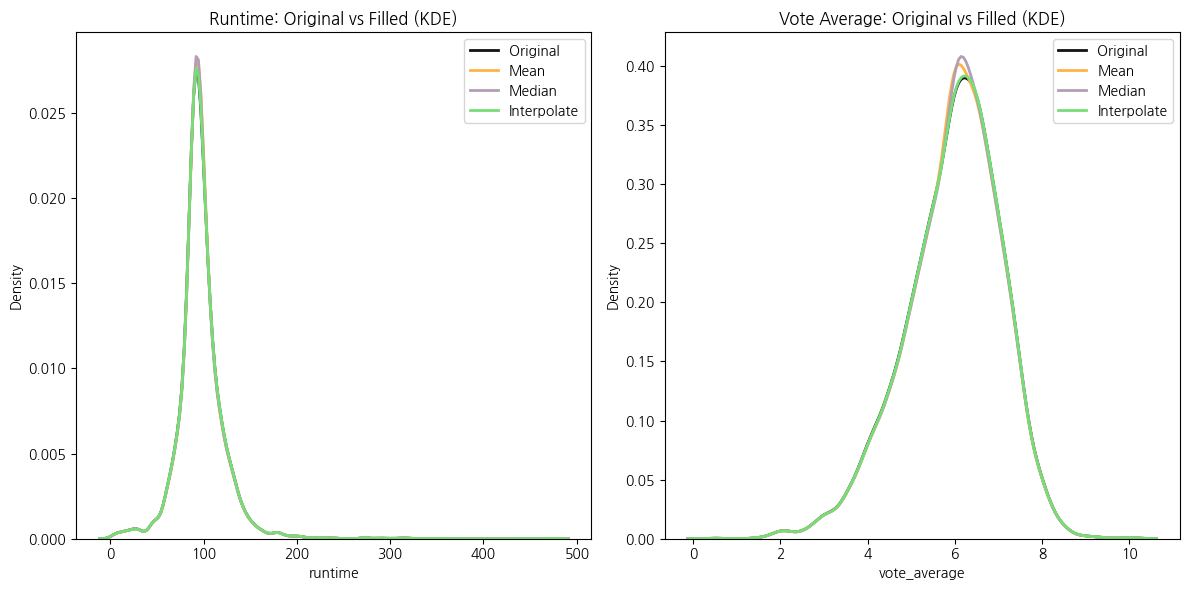

In [36]:
# 시각화 - 각 방법의 분포 비교
plt.figure(figsize=(12, 6))
colors = ['#121212', '#FFB347', '#B39EB5', '#77DD77']  # 팔레트 색상 정의

# Runtime comparison using KDE
plt.subplot(1, 2, 1)
sns.kdeplot(df['runtime'].dropna(), label='Original', color=colors[0], linewidth=2)
sns.kdeplot(df['runtime_mean'], label='Mean', color=colors[1], linewidth=2)
sns.kdeplot(df['runtime_median'], label='Median', color=colors[2], linewidth=2)
sns.kdeplot(df['runtime_interpolate'], label='Interpolate', color=colors[3], linewidth=2)
plt.title('Runtime: Original vs Filled (KDE)')
plt.legend()

# Vote Average comparison using KDE
plt.subplot(1, 2, 2)
sns.kdeplot(df['vote_average'].dropna(), label='Original', color=colors[0], linewidth=2)
sns.kdeplot(df['vote_average_mean'], label='Mean', color=colors[1], linewidth=2)
sns.kdeplot(df['vote_average_median'], label='Median', color=colors[2], linewidth=2)
sns.kdeplot(df['vote_average_interpolate'], label='Interpolate', color=colors[3], linewidth=2)
plt.title('Vote Average: Original vs Filled (KDE)')
plt.legend()

plt.tight_layout()
plt.show()

In [37]:
# Shapiro-Wilk 테스트 결과 저장
def shapiro_test(column):
    stat, p_value = stats.shapiro(column)
    return p_value

# 정규성 테스트 결과 출력
def print_shapiro_results(df, col_name):
    print(f"\nShapiro-Wilk Test for '{col_name}':")
    print(f"Original: {shapiro_test(df[col_name].dropna()):.4f}")
    print(f"Mean: {shapiro_test(df[f'{col_name}_mean']):.4f}")
    print(f"Median: {shapiro_test(df[f'{col_name}_median']):.4f}")
    print(f"Interpolate: {shapiro_test(df[f'{col_name}_interpolate']):.4f}")

In [38]:
# Shapiro-Wilk 테스트 결과
print_shapiro_results(df, 'runtime')
print_shapiro_results(df, 'vote_average')


Shapiro-Wilk Test for 'runtime':
Original: 0.0000
Mean: 0.0000
Median: 0.0000
Interpolate: 0.0000

Shapiro-Wilk Test for 'vote_average':
Original: 0.0000
Mean: 0.0000
Median: 0.0000
Interpolate: 0.0000


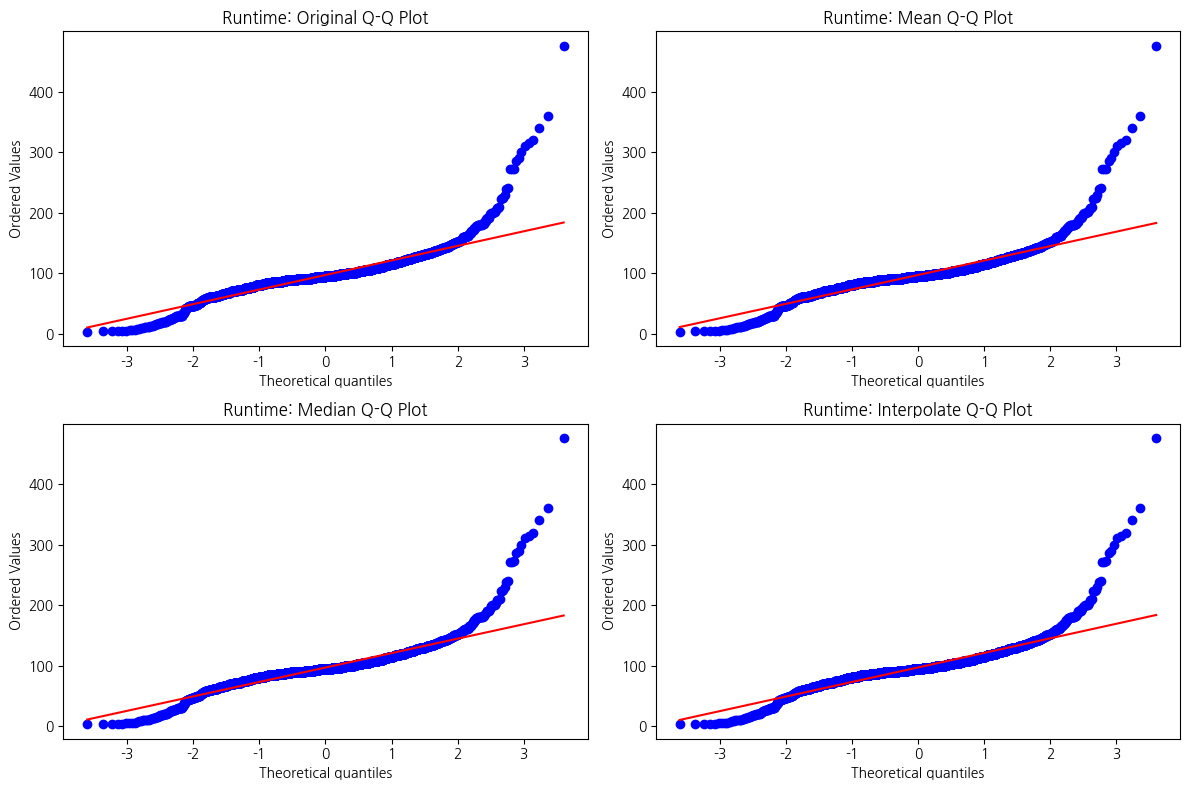

In [39]:
# Q-Q 플롯 시각화
plt.figure(figsize=(12, 8))

# 색상 팔레트 정의
colors = ['#AEC6CF', '#FFB347', '#B39EB5', '#77DD77']

# Runtime Q-Q plot comparison
plt.subplot(2, 2, 1)
stats.probplot(df['runtime'].dropna(), dist="norm", plot=plt)
plt.title('Runtime: Original Q-Q Plot')

plt.subplot(2, 2, 2)
stats.probplot(df['runtime_mean'], dist="norm", plot=plt)
plt.title('Runtime: Mean Q-Q Plot')

plt.subplot(2, 2, 3)
stats.probplot(df['runtime_median'], dist="norm", plot=plt)
plt.title('Runtime: Median Q-Q Plot')

plt.subplot(2, 2, 4)
stats.probplot(df['runtime_interpolate'], dist="norm", plot=plt)
plt.title('Runtime: Interpolate Q-Q Plot')

plt.tight_layout()
plt.show()

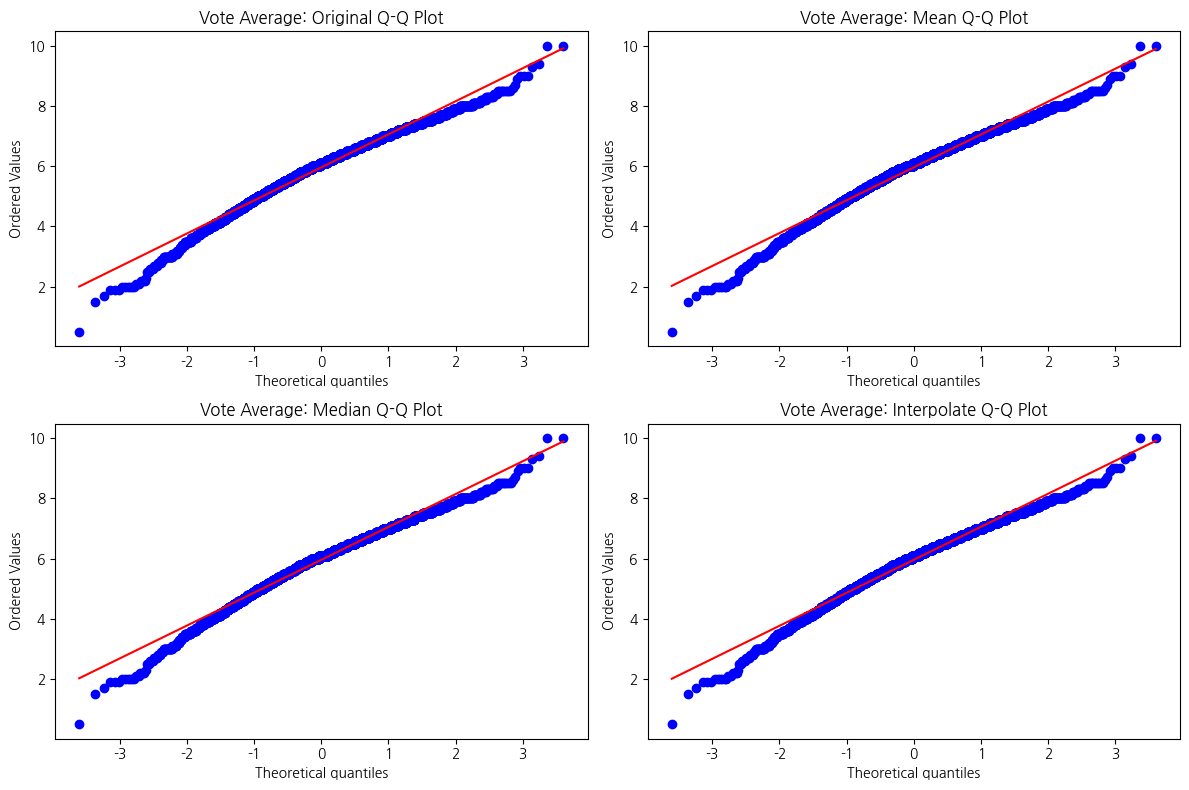

In [40]:
# Vote Average Q-Q plot comparison
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
stats.probplot(df['vote_average'].dropna(), dist="norm", plot=plt)
plt.title('Vote Average: Original Q-Q Plot')

plt.subplot(2, 2, 2)
stats.probplot(df['vote_average_mean'], dist="norm", plot=plt)
plt.title('Vote Average: Mean Q-Q Plot')

plt.subplot(2, 2, 3)
stats.probplot(df['vote_average_median'], dist="norm", plot=plt)
plt.title('Vote Average: Median Q-Q Plot')

plt.subplot(2, 2, 4)
stats.probplot(df['vote_average_interpolate'], dist="norm", plot=plt)
plt.title('Vote Average: Interpolate Q-Q Plot')

plt.tight_layout()
plt.show()

큰 차이가 없어보입니다. 그래도 이상치로 보이는 값은 존재하므로 중앙값으로 대치하겠습니다.

In [41]:
mvmd_cleaned['runtime'] = fill_with_median(mvmd_cleaned, 'runtime')
mvmd_cleaned['vote_average'] = fill_with_median(mvmd_cleaned, 'vote_average')

In [42]:
mvmd_cleaned.head()

,belongs_to_collection,genres,id,imdb_id,production_companies,release_date,runtime,spoken_languages,title,vote_average
0,Toy Story Collection,"Animation, Comedy, Family",862,tt0114709,Pixar Animation Studios,1995-10-30,81.0,en,Toy Story,7.7
1,Grumpy Old Men Collection,"Romance, Comedy",15602,tt0113228,"Warner Bros., Lancaster Gate",1995-12-22,101.0,en,Grumpier Old Men,6.5
2,Father of the Bride Collection,Comedy,11862,tt0113041,"Sandollar Productions, Touchstone Pictures",1995-02-10,106.0,en,Father of the Bride Part II,5.7
3,James Bond Collection,"Adventure, Action, Thriller",710,tt0113189,"United Artists, Eon Productions",1995-11-16,130.0,"en, ru, es",GoldenEye,6.6
4,Balto Collection,"Family, Animation, Adventure",21032,tt0112453,"Universal Pictures, Amblin Entertainment, Ambl...",1995-12-22,78.0,en,Balto,7.1


In [43]:
mvmd_cleaned.isnull().sum()

belongs_to_collection    0
genres                   0
id                       0
imdb_id                  0
production_companies     0
release_date             0
runtime                  0
spoken_languages         0
title                    0
vote_average             0
dtype: int64

# 2. 가설 검정

행이 30개 이상이므로 중심 극한 정리에 따라 정규성을 따른다고 가정합니다.

## 수치형 데이터

### `runtime` -> `vote_average`

In [44]:
# 상관계수 계산
mvmd_numeric = mvmd_cleaned[['runtime','vote_average']].copy()
correlation_matrix = mvmd_numeric.corr(method='pearson')

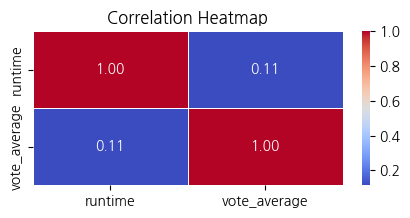

In [45]:
# 히트맵 시각화
plt.figure(figsize=(5, 2))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

### 구간별 `runtime` -> `vote_average`

In [46]:
mvmd_cleaned['runtime'].describe()

count    4419.000000
mean       96.997511
std        26.136932
min         3.000000
25%        86.000000
50%        95.000000
75%       106.000000
max       476.000000
Name: runtime, dtype: float64

In [47]:
# runtime을 구간으로 나누기
# IQR 계산
Q1 = mvmd_cleaned['runtime'].quantile(0.25)
Q3 = mvmd_cleaned['runtime'].quantile(0.75)
IQR = Q3 - Q1

# 구간 정의
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# IQR을 사용하여 구간 정의 (이상치를 제외한 구간)
bins = [0, lower_bound, upper_bound, mvmd_cleaned['runtime'].max()]
labels = ['Below Lower Bound', 'Within IQR', 'Above Upper Bound']
mvmd_cleaned['runtime_bin'] = pd.cut(mvmd_cleaned['runtime'], bins=bins, labels=labels, right=True)

In [48]:
# 각 구간별 상관계수 계산
# 각 구간에 대해 상관계수를 계산하기 위해 빈 DataFrame 생성
correlation_per_bin = {}

# 구간별 상관관계 분석
for label in labels:
    mvmd_bin = mvmd_cleaned[mvmd_cleaned['runtime_bin'] == label]
    if mvmd_bin.shape[0] > 1:  # 각 구간에 충분한 데이터가 있을 때만 분석
        mvmd_numeric_bin = mvmd_bin[['runtime','vote_average']].copy()
        correlation_matrix_bin = mvmd_numeric_bin.corr(method='pearson')
        correlation_per_bin[label] = correlation_matrix_bin

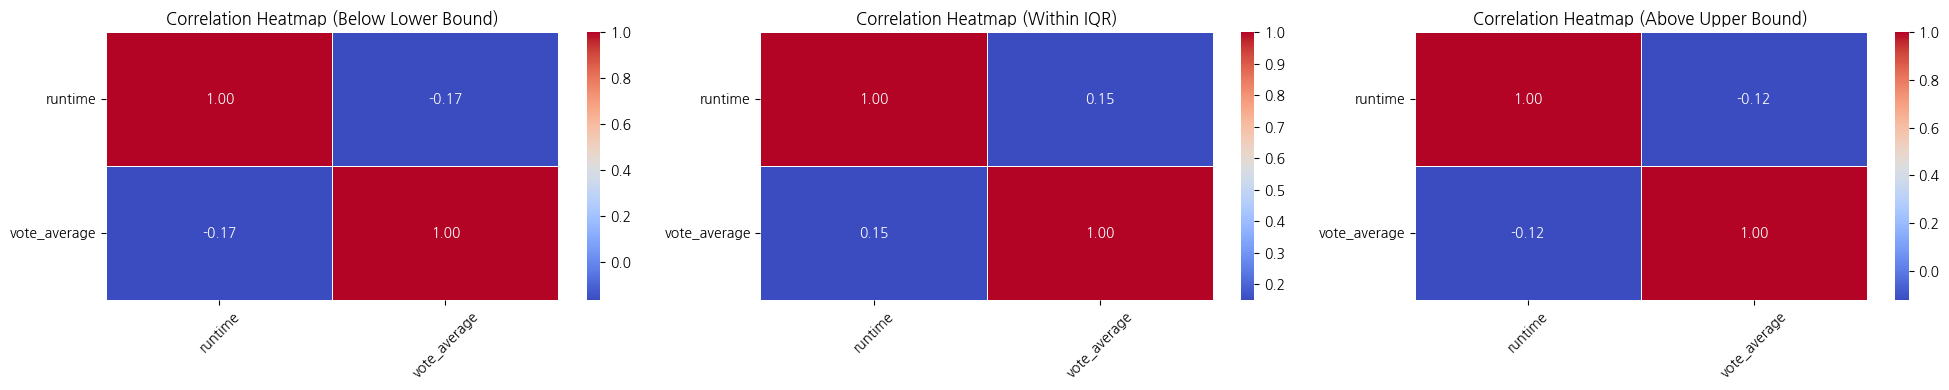

In [49]:
# 히트맵 시각화
fig, axes = plt.subplots(nrows=1, ncols=len(labels), figsize=(20, 4))

for ax, (label, corr_matrix) in zip(axes, correlation_per_bin.items()):
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5, ax=ax)
    ax.set_title(f'Correlation Heatmap ({label})')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

plt.tight_layout()
plt.show()

유의한 상관관계는 없는 것으로 보입니다.

## 범주형 데이터

범주형 데이터이므로 등분산 검정을 시행한 뒤, 결과에 따라 ANOVA나 Kruskal-Wallis H를 시행합니다.

In [50]:
# release_date에서 연도 추출
mvmd_cleaned['release_year'] = pd.to_datetime(mvmd_cleaned['release_date']).dt.year

In [51]:
# 쉼표로 구분된 문자열을 개별 행으로 분리
def explode_comma_separated_column(df, column_name):
    # 쉼표로 구분된 문자열을 리스트로 변환
    df[column_name] = df[column_name].str.split(',')

    # 리스트를 행으로 분리
    exploded_df = df.explode(column_name)

    # 공백 제거
    exploded_df[column_name] = exploded_df[column_name].str.strip()

    return exploded_df

In [52]:
# 각 행에 대해 분리된 값을 새로운 행으로 저장
mvmd_cleaned = explode_comma_separated_column(mvmd_cleaned, 'spoken_languages')
mvmd_cleaned = explode_comma_separated_column(mvmd_cleaned, 'production_companies')
mvmd_cleaned = explode_comma_separated_column(mvmd_cleaned, 'genres')

# 결과 출력
mvmd_cleaned.head()

,belongs_to_collection,genres,id,imdb_id,production_companies,release_date,runtime,spoken_languages,title,vote_average,runtime_bin,release_year
0,Toy Story Collection,Animation,862,tt0114709,Pixar Animation Studios,1995-10-30,81.0,en,Toy Story,7.7,Within IQR,1995
0,Toy Story Collection,Comedy,862,tt0114709,Pixar Animation Studios,1995-10-30,81.0,en,Toy Story,7.7,Within IQR,1995
0,Toy Story Collection,Family,862,tt0114709,Pixar Animation Studios,1995-10-30,81.0,en,Toy Story,7.7,Within IQR,1995
1,Grumpy Old Men Collection,Romance,15602,tt0113228,Warner Bros.,1995-12-22,101.0,en,Grumpier Old Men,6.5,Within IQR,1995
1,Grumpy Old Men Collection,Comedy,15602,tt0113228,Warner Bros.,1995-12-22,101.0,en,Grumpier Old Men,6.5,Within IQR,1995


### 등분산 검정

정규성을 만족한다고 가정했으므로 Bartlett's test를 시행합니다.

In [53]:
# Bartlett's test 함수 정의
def bartlett_test(df, column):
    categories = df[column].unique()
    groups = [df[df[column] == category]['vote_average'].dropna() for category in categories]

    # Bartlett's test
    stat, p_val = stats.bartlett(*groups)
    return stat, p_val

In [54]:
# 범주형 변수 목록
mvmd_categorical = ['release_year', 'spoken_languages', 'production_companies', 'genres']

# 검정 결과 저장
bartlett_results = {}

for column in mvmd_categorical:
    if mvmd_cleaned[column].nunique() > 1:  # 유의미한 검정을 위해 최소 두 개 이상의 카테고리가 있어야 함
        stat, p_val = bartlett_test(mvmd_cleaned, column)
        bartlett_results[column] = {'Bartlett Stat': stat, 'Bartlett p-value': p_val}

# 결과 출력
for column, metrics in bartlett_results.items():
    print(f"\nBartlett's Test Results for {column}:")
    print(f"Statistic: {metrics['Bartlett Stat']}")
    print(f"p-value: {metrics['Bartlett p-value']}")


Bartlett's Test Results for release_year:
Statistic: nan
p-value: nan

Bartlett's Test Results for spoken_languages:
Statistic: inf
p-value: 0.0

Bartlett's Test Results for production_companies:
Statistic: nan
p-value: nan

Bartlett's Test Results for genres:
Statistic: 291.0057155370357
p-value: 1.3888487777007638e-50


등분산을 가정하지 않는다고 볼 수 있습니다.

### Kruskal Wallis 검정

In [55]:
mvmd_cleaned['release_year'] = mvmd_cleaned['release_year'].astype(str)

In [56]:
# ANOVA 함수 정의
def anova_test(df, column):
    categories = df[column].unique()
    groups = [df[df[column] == category]['vote_average'].dropna() for category in categories]

    f_val, p_val = stats.f_oneway(*groups)
    return f_val, p_val

In [57]:
# 검정 결과 저장
results = {}

for column in mvmd_categorical:
    if mvmd_cleaned[column].nunique() > 1:  # 유의미한 검정을 위해 최소 두 개 이상의 카테고리가 있어야 함
        f_val, p_val = anova_test(mvmd_cleaned, column)
        results[column] = {'ANOVA F-value': f_val, 'ANOVA p-value': p_val}

# 결과 출력
for column, metrics in results.items():
    print(f"\nResults for {column}:")
    print(f"ANOVA F-value: {metrics['ANOVA F-value']}")
    print(f"ANOVA p-value: {metrics['ANOVA p-value']}")


Results for release_year:
ANOVA F-value: 20.32857662638956
ANOVA p-value: 0.0

Results for spoken_languages:
ANOVA F-value: 24.083607566189368
ANOVA p-value: 2.7552214404e-314

Results for production_companies:
ANOVA F-value: 12.620605071386205
ANOVA p-value: 0.0

Results for genres:
ANOVA F-value: 100.13297961207152
ANOVA p-value: 0.0


이들은 모두 p-value가 0.05보다 작으므로, 각 변수의 그룹 간 평균 차이는 통계적으로 유의미하다고 할 수 있습니다.